In [51]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from config import LMDB_USE_COMPRESSION

import lmdb
import os
import msgpack

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [52]:
def imname_to_target(name:str) -> tuple[float, float]:
    name = name.split('.jpg')[0]
    x, y = name.split("_")
    x = float(x[1:])
    if y[1] == '-':
        y = float(y[1:6])
    else:
        y = float(y[1:5])
    return x, y

In [53]:
class LMDBImageDataset(Dataset):
    def __init__(self, lmdb_path, transforms=None, keys_fname="keys.txt", flatten_data=True):
        self.keys = None
        self.transforms = transforms

        with open(os.path.join(lmdb_path, keys_fname)) as f:
            self.keys = f.readlines()
            if self.keys[-1] == '':
                self.keys = self.keys[:-1]
        for i in range(len(self.keys)):
            self.keys[i] = self.keys[i].replace("\n", "")

        self.labels = []
        for i, key in enumerate(self.keys):
            try:
                self.labels.append(imname_to_target(key))
            except Exception as e:
                print("i:", i)
                print("name:", key)
                raise e

        for i in range(len(self.keys)):
            self.keys[i] = self.keys[i].encode()

        self.lmdb_path = lmdb_path
        self.flatten_data = flatten_data

    def open_lmdb(self):
        self.env = lmdb.open(self.lmdb_path, readonly=True, create=False, lock=False, readahead=False, meminit=False)
        self.txn = self.env.begin()

    def close(self):
        self.env.close()

    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, index):
        if not hasattr(self, 'txn'):
            print("Opening lmdb txn")
            self.open_lmdb()
        key = self.keys[index]
        label = self.labels[index]
        
        img_bytes = self.txn.get(key)
        if img_bytes is None:
            raise KeyError(f"Image {key} not found in LMDB!")

        if LMDB_USE_COMPRESSION:
            img_bytes = lz4.frame.decompress(img_bytes)

        image = np.array(msgpack.unpackb(img_bytes, raw=False), dtype=np.uint8)
        if not self.flatten_data:
            if len(image.shape)==2:
                image = torch.from_numpy(np.array([image])).float()
            if len(image.shape)==3:
                image = torch.from_numpy(np.array(image)).float()
                image = image.permute(2, 0, 1)
        image = image / 255.0

        if self.transforms is not None:
            image = self.transforms(image)

        if self.flatten_data:
            image = torch.from_numpy(image).flatten().float()
        elif isinstance(image, np.ndarray):
            image = torch.unsqueeze(torch.from_numpy(image), 0)

        x, y = label
        x = (x + 2) / 5.7
        y = (y + 2) / 4
        label = torch.tensor((x, y), dtype=torch.float32)

        return image, label


In [54]:
class LMDBDoGTripletDataset(LMDBImageDataset):
    def __getitem__(self, index):
        if not hasattr(self, 'txn'):
            self.open_lmdb()

        base_key_bytes = self.keys[index]
        base_key_str = base_key_bytes.decode()
        dark_key = base_key_str.replace('-light.jpg', '.jpg').replace('-mainlight.jpg', '.jpg')
        light_key = dark_key.replace('.jpg', '-light.jpg')
        mainlight_key = dark_key.replace('.jpg', '-mainlight.jpg')

        keys = [dark_key.encode(), light_key.encode(), mainlight_key.encode()]

        def load_image(key):
            try:
                img_bytes = self.txn.get(key)
                if img_bytes is None:
                    return None
                if LMDB_USE_COMPRESSION:
                    img_bytes = lz4.frame.decompress(img_bytes)
                img_np = np.array(msgpack.unpackb(img_bytes, raw=False), dtype=np.uint8)
                img_tensor = torch.from_numpy(img_np).float()
                if img_tensor.ndim == 3:
                    img_tensor = img_tensor.permute(2, 0, 1)
                img_tensor = img_tensor / 255.0
                if self.transforms:
                    img_tensor = self.transforms(img_tensor)
                return img_tensor
            except Exception as e:
                return None

        dark = load_image(keys[0])
        light = load_image(keys[1])
        mainlight = load_image(keys[2])

        if dark is None or light is None or mainlight is None:
            return None

        return {'dark': dark, 'light': light, 'mainlight': mainlight, 'name': base_key_str}


In [55]:
class LearnableNormalizer(nn.Module):
    def __init__(self, kernel_size=15, sigma=3.5, a=3, d=1):
        super().__init__()
        self.conv = nn.Conv2d(3, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.init_weights(kernel_size, sigma, a, d)
        self.activaltion = nn.Sigmoid()
    def gaussian_kernel(self, kernel_size, sigma):
        """Create 2D Gaussian kernel centered in the middle."""
        ax = torch.linspace(-(kernel_size - 1) / 2., (kernel_size - 1) / 2., kernel_size)
        xx, yy = torch.meshgrid(ax, ax, indexing='ij')
        kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
        return kernel

    def init_weights(self, kernel_size, sigma, a, d):
        with torch.no_grad():
            self.conv.weight.zero_()
            kernel = self.gaussian_kernel(kernel_size, sigma)
            weighted_kernel = kernel * a - d
            for c in range(3):
                self.conv.weight[0, c] = weighted_kernel

    def forward(self, x):
        return self.activaltion(self.conv(x))

In [56]:
config = {
    "data_folder": "/mnt/e/color.lmdb",
    "dataset_train_keys_fname": "016_color_train.txt"    
}

In [57]:
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    darks = torch.stack([b['dark'] for b in batch])
    lights = torch.stack([b['light'] for b in batch])
    mainlights = torch.stack([b['mainlight'] for b in batch])
    names = [b['name'] for b in batch]
    return {'dark': darks, 'light': lights, 'mainlight': mainlights, 'name': names}


In [68]:
dataset = LMDBDoGTripletDataset(config["data_folder"], flatten_data=False, keys_fname=config["dataset_train_keys_fname"])
model = LearnableNormalizer(kernel_size=15).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
    drop_last=True,
    prefetch_factor=2,
)

In [65]:
model.train()
num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0.0
    progress = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in progress:
        if batch is None:
            continue

        dark = batch['dark'].cuda()         # [B, 3, H, W]
        light = batch['light'].cuda()
        mainlight = batch['mainlight'].cuda()

        # Forward passes
        out_dark = model(dark)              # [B, 1, H, W]
        out_light = model(light)
        out_mainlight = model(mainlight)

        # Derive target from dark: threshold
        target = dark.mean(dim=1, keepdim=True)  # Convert to grayscale [B, 1, H, W]
        target = target.clone()
        target[target < (120 / 255.0)] = 0.0

        # L1 Loss
        loss = (
            F.mse_loss(out_dark, target) +
            F.mse_loss(out_light, target) +
            F.mse_loss(out_mainlight, target)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        avg_loss = total_loss / (progress.n + 1)
        progress.set_postfix(loss=avg_loss)

    print(f"Epoch {epoch+1} complete - Average Loss: {avg_loss:.4f}")

Epoch 1/5: 100%|██████████| 135/135 [02:00<00:00,  1.12it/s, loss=0.183]


Epoch 1 complete - Average Loss: 0.1834


Epoch 2/5: 100%|██████████| 135/135 [02:01<00:00,  1.11it/s, loss=0.182]


Epoch 2 complete - Average Loss: 0.1818


Epoch 3/5: 100%|██████████| 135/135 [02:01<00:00,  1.12it/s, loss=0.181]


Epoch 3 complete - Average Loss: 0.1815


Epoch 4/5: 100%|██████████| 135/135 [02:02<00:00,  1.10it/s, loss=0.181]


Epoch 4 complete - Average Loss: 0.1812


Epoch 5/5: 100%|██████████| 135/135 [02:02<00:00,  1.11it/s, loss=0.181]

Epoch 5 complete - Average Loss: 0.1809


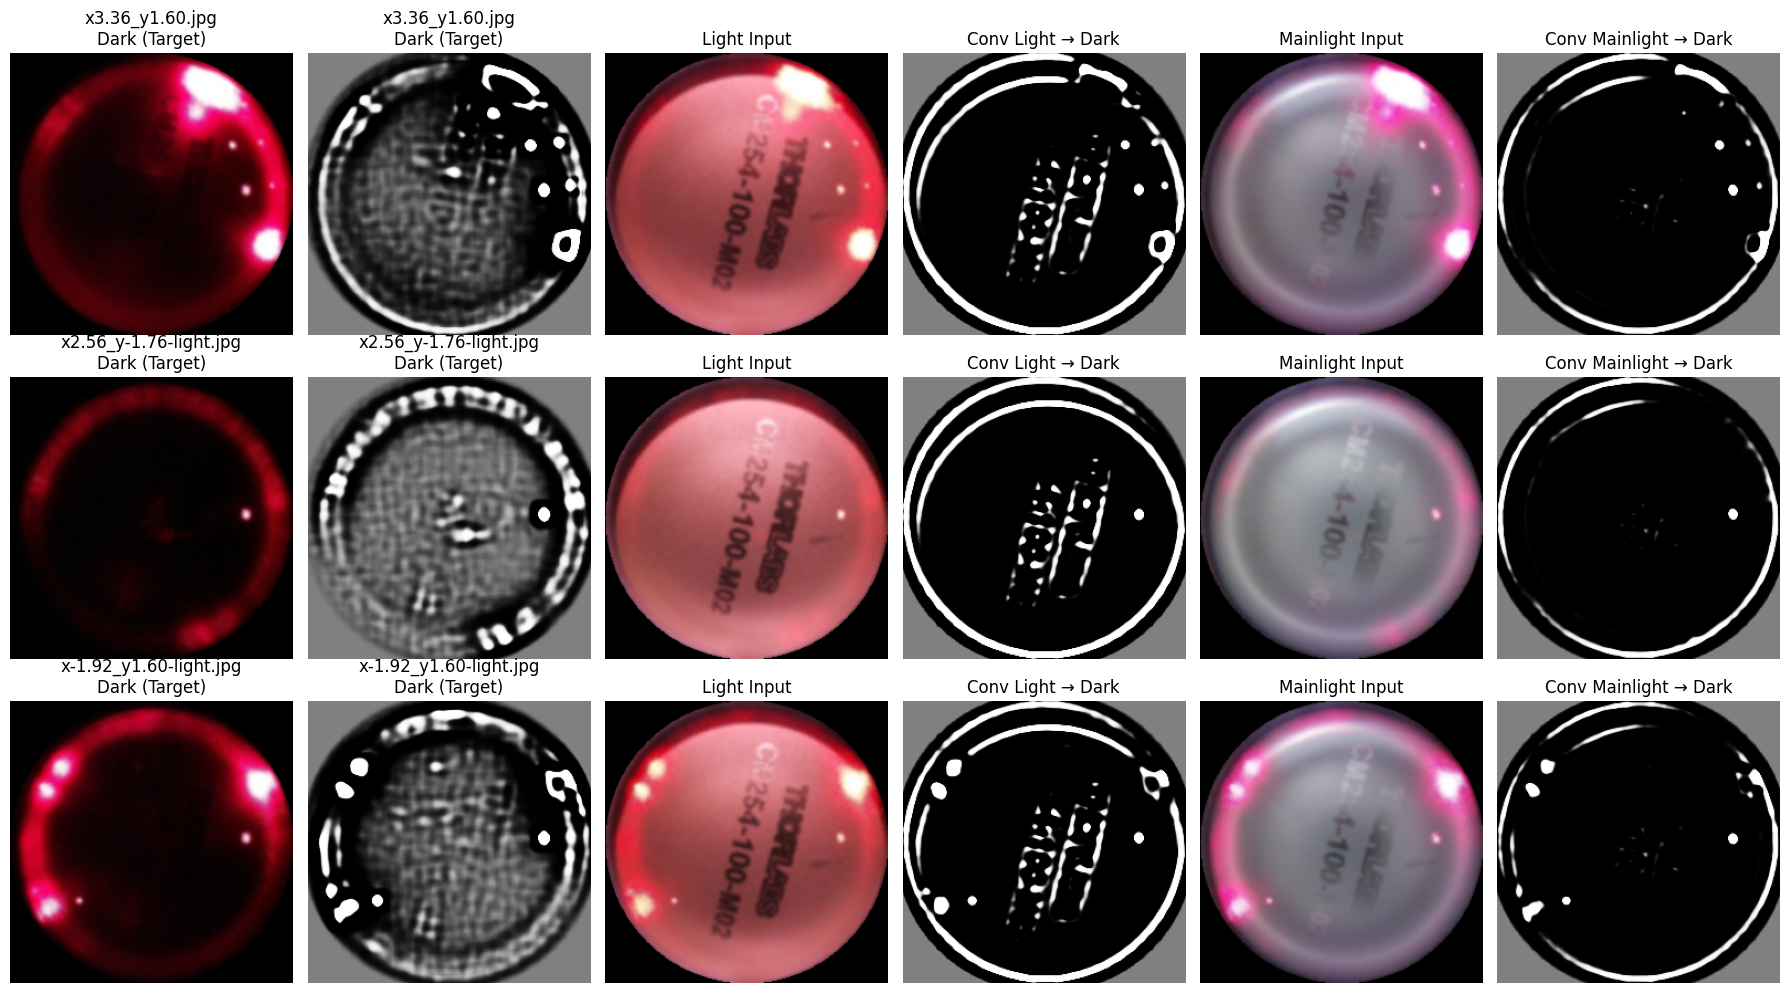

In [69]:
model.eval()
samples = [dataset[i] for i in range(3)]

fig, axes = plt.subplots(3, 6, figsize=(18, 10))
for i, sample in enumerate(samples):
    dark = sample['dark'].unsqueeze(0).cuda()
    light = sample['light'].unsqueeze(0).cuda()
    mainlight = sample['mainlight'].unsqueeze(0).cuda()
    name = sample['name']

    with torch.no_grad():
        norm_dark = model(dark).squeeze(0).cpu()
        norm_light = model(light).squeeze(0).cpu()
        norm_mainlight = model(mainlight).squeeze(0).cpu()

    axes[i, 0].imshow(sample['dark'].permute(1, 2, 0).cpu())
    axes[i, 0].set_title(f"{name}\nDark (Target)")

    axes[i, 1].imshow(norm_dark.clamp(0, 1).permute(1, 2, 0).cpu(), cmap='gray')
    axes[i, 1].set_title(f"{name}\nDark (Target)")

    axes[i, 2].imshow(sample['light'].permute(1, 2, 0).cpu())
    axes[i, 2].set_title("Light Input")

    axes[i, 3].imshow(norm_light.clamp(0, 1).permute(1, 2, 0), cmap='gray')
    axes[i, 3].set_title("Conv Light → Dark")

    axes[i, 4].imshow(sample['mainlight'].permute(1, 2, 0).cpu())
    axes[i, 4].set_title("Mainlight Input")

    axes[i, 5].imshow(norm_mainlight.clamp(0, 1).permute(1, 2, 0), cmap='gray')
    axes[i, 5].set_title("Conv Mainlight → Dark")

for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

plt.tight_layout()
plt.show()